### [Optional] Step 1: Parsing Contact Information 

In [ ]:
path_to_your_vcard_file = 'All_Contacts.vcf'

In [ ]:
# Add imports at the top
import json
import os
from training_utils import parse_vcard_file

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)
# Parse contacts and save to file
contacts_dict = parse_vcard_file(path_to_your_vcard_file)
# Save the dictionary to a JSON file
with open('data/imessage/contacts_dict.json', 'w') as f:
    json.dump(contacts_dict, f, indent=2)
# Print confirmation
print(f"Saved {len(contacts_dict)} contacts to data/contacts_dict.json")

# Optional: Print the results (for verification)
for phone, name in contacts_dict.items():
    print(f"Phone: {phone} -> Name: {name}")

### Step 2: Filtering out low quality conversations

In [ ]:
import os
import re

def count_messages(content):
    # Split by timestamp pattern to count messages
    # This pattern matches timestamps like "Aug 25, 2021  5:17:24 PM"
    messages = re.split(r'\w{3}\s+\d{1,2},\s+\d{4}\s+\d{1,2}:\d{2}:\d{2}\s+[AP]M', content)
    # Filter out empty strings from the split
    return len([m for m in messages if m.strip()])

def contains_me_messages(content):
    # Look for lines starting with "Me"
    return bool(re.search(r'^Me\n', content, re.MULTILINE))

def filter_messages(directory):
    # Get all .txt files in the directory
    files = [f for f in os.listdir(directory) if f.endswith('.txt')]
    
    for filename in files:
        filepath = os.path.join(directory, filename)
        
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
            
        # Check our filtering conditions
        message_count = count_messages(content)
        has_me = contains_me_messages(content)
        
        # If file should be deleted (20 or fewer messages OR no "Me" messages)
        if message_count <= 20 or not has_me:
            print(f"Deleting {filename}: {message_count} messages, contains 'Me' messages: {has_me}")
            os.remove(filepath)
        else:
            print(f"Keeping {filename}: {message_count} messages, contains 'Me' messages: {has_me}")

# Run the filter on the specified directory
filter_messages('data/iMessage/imessage_export')

### [Optional] Step 3: Matching Contacts to Conversations 

In [ ]:
from training_utils import process_imessage_files

directory = 'data/imessage/imessage_export'
contacts_dict_path = 'data/imessage_contacts_dict.json'
process_imessage_files(directory, contacts_dict_path)

Checking for unmatched numbers: can fix if you'd like.

In [ ]:
import re
import glob

def get_unmatched_numbers():
    # Pattern for timestamp lines
    timestamp_pattern = r"[A-Z][a-z]{2} \d{1,2}, \d{4}\s+\d{1,2}:\d{2}:\d{2} [AP]M"
    # Pattern for phone numbers (matches +1XXXXXXXXXX or XXXXXXXXXX format)
    phone_pattern = r'(?:\+\d{1,2})?[2-9]\d{9}'
    
    # Set to store unique unmatched numbers
    unmatched_numbers = set()
    
    # Get all message files
    message_files = glob.glob('data/iMessage/imessage_export/*.txt')
    
    for file_path in message_files:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            
        for i, line in enumerate(lines):
            # If we find a timestamp, check the next line for a phone number
            if re.match(timestamp_pattern, line.strip()):
                if i + 1 < len(lines):  # Make sure we have a next line
                    next_line = lines[i + 1].strip()
                    if re.match(phone_pattern, next_line):
                        unmatched_numbers.add(next_line)
    
    # Print results
    print("Unmatched phone numbers:")
    for number in sorted(unmatched_numbers):
        print(number)

get_unmatched_numbers()

In [ ]:
def analyze_all_messages(directory: str):
    """
    Analyze all message files and return total counts of speakers, phone numbers, and names.
    """
    # Pattern for phone numbers (matches +1XXXXXXXXXX, XXXXXXXXXX, or +XXXXXXXXXXX format)
    phone_pattern = r'(?:\+1)?[2-9]\d{9}|\+\d{11}'
    
    # Sets to store unique speakers across all files
    all_speakers = set()
    all_phones = set()
    all_names = set()
    
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
                content = f.read()
                
                # Split by timestamp pattern
                timestamp_pattern = r'[A-Z][a-z]{2} \d{1,2}, \d{4}\s+\d{1,2}:\d{2}:\d{2} [AP]M'
                messages = re.split(timestamp_pattern, content)
                
                for message in messages:
                    # Look for lines that could be speakers (first line after timestamp)
                    lines = message.strip().split('\n')
                    if lines and lines[0]:  # If there are lines and first line isn't empty
                        speaker = lines[0].strip()
                        if speaker and speaker != "Tapbacks:" and not speaker.startswith('Find My:'):
                            all_speakers.add(speaker)
    
    # Categorize all speakers
    all_phones = set(speaker for speaker in all_speakers if re.match(phone_pattern, speaker))
    all_names = all_speakers - all_phones - {'Me'}  # Exclude 'Me' from named speakers
    
    print(f"\nTotal Analysis:")
    print(f"Total unique speakers: {len(all_speakers)}")
    print(f"Unmatched phone numbers: {len(all_phones)}")
    print(f"Named speakers: {len(all_names)}")
    
    # Optionally print the actual phone numbers that need to be replaced
    if all_phones:
        print("\nPhone numbers that still need to be replaced:")
        for phone in sorted(all_phones):
            print(phone)

# Run analysis
analyze_all_messages('data/iMessage/imessage_export')

There may be contacts that were omitted in your vcf file, hence why you see unmatched numbers. Feel free to supplement here in the updates dictionary.

In [ ]:
# Define the updates
updates = {
    '13042223333': 'John Doe', # Phone number to Name
}

import json

# Load the existing dictionary
with open('data/imessage/contacts_dict.json', 'r') as f:
    contacts_dict = json.load(f)

# Update the dictionary
contacts_dict.update(updates)

# Save the updated dictionary back to the file
with open('data/imessage/contacts_dict.json', 'w') as f:
    json.dump(contacts_dict, f, indent=2)

# Print confirmation
print("Updated contacts dictionary with the following changes:")
for phone, name in updates.items():
    print(f"Phone: {phone} -> Name: {name}")
print(f"\nTotal contacts in dictionary: {len(contacts_dict)}")

### Step 4: Parsing the Conversations!

In [ ]:
from training_utils import IMessageParser
import glob
import os

# Initialize the parser
parser = IMessageParser()

# Get all .txt files in the export directory
message_files = glob.glob('data/imessage/imessage_export/unprocessed/*.txt')

# Process each file
for file_path in message_files:
    # Get base filename without extension for output file naming
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    output_path = f'data/imessage/parsed/{base_name}.json'
    
    # Parse conversations from the file
    conversations = parser.parse(file_path)
    
    # Save the parsed conversations
    parser.save_conversations(conversations, output_path)
    
    # Print progress
    print(f"Parsed {len(conversations)} conversations from {base_name}")

print("\nDone! All conversations have been parsed and saved to data/imessage/parsed/")

In [ ]:
import json
import glob
import os

def combine_consecutive_messages(messages, delimiter='<|msg|>'):
    """
    Combines consecutive messages from the same sender into a single message.
    Uses a unique delimiter that's unlikely to appear in natural conversation.
    """
    if not messages:
        return messages

    combined = []
    current_group = messages[0].copy()

    for msg in messages[1:]:
        if msg['speaker'] == current_group['speaker']:
            # Combine with delimiter
            current_group['content'] += delimiter + msg['content']
        else:
            # Add the current group to combined list and start a new group
            combined.append(current_group)
            current_group = msg.copy()
    
    # Don't forget to add the last group
    combined.append(current_group)
    
    return combined

# Create new output directory
output_dir = 'data/imessage/parsed_combined'
os.makedirs(output_dir, exist_ok=True)

# Process all JSON files in the parsed directory
parsed_files = glob.glob('data/imessage/parsed/*.json')

for file_path in parsed_files:
    # Read the JSON file
    with open(file_path, 'r') as f:
        conversations = json.load(f)
    
    # Process each conversation in the list
    processed_conversations = [
        combine_consecutive_messages(conversation)
        for conversation in conversations
    ]
    
    # Save to new directory with same filename
    output_path = os.path.join(output_dir, os.path.basename(file_path))
    with open(output_path, 'w') as f:
        json.dump(processed_conversations, f, indent=2)
    
    print(f"Processed {file_path} -> {output_path}")

print(f"\nDone! All files have been processed and saved to {output_dir}")

### Step 5: Creating a Conversation Store

In [ ]:
from training_utils import load_and_sort_conversations

directory = 'data/imessage/parsed_combined'
recent_convos = load_and_sort_conversations(
    directory, 
    num_conversations=500, 
    min_messages=15,
    max_messages=75,
)

Loaded 2020 conversations with 15-75 messages
Kept 500 most recent conversations


In [ ]:
conversation_store_save_path = "IMPersona/data/ben/conversation_store.json"
with open(conversation_store_save_path, "w") as f:
    json.dump(recent_convos, f, indent=2)

### Step 6: [Optional if not Training] Creating the Training Set

In [1]:
from IMPersona.loader import MessageLoader
from IMPersona.formatter import LlamaFormatter

# Load and prepare dataset
loader = MessageLoader(conversations_dir="data/imessage/parsed_combined", formatter=LlamaFormatter())
full_dataset_imessage = loader.generate_full_dataset(conversation_buffer=0)

# Sort by timestamp
full_dataset_imessage = full_dataset_imessage.sort("timestamp")

/scratch/gpfs/qbshi/.conda/pkgs/new_impersona/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Filtering out low quality (not necessarily bad) conversations:

Filter Criteria: 
- "GamePigeon message:"
- URLs in the output
- Excessive word repetition in the output
- More than 20 consecutive messages
- Filter out group chats
- Filter out messages that only contain emoji responses
- Conversations with more than 30 messages
- One individual message is not too long (longer than 50 words)
- Beginning of conversations (Input has no messages): early in conversation where there are not enough cues on what to talk about.

B60k: Virtually no filtering.
B45k: GamePigeon, URLs, Repetition
B25k: Group chats, emojis, long converastions, one individual messags is not too long, beginning of conversations
B15k: + conversations must have lasted at least 7 messages.

In [2]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re

# Download stopwords if not already downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

STOP_WORDS = set(stopwords.words('english'))
# Add additional common words you don't want to count
STOP_WORDS.update(['yeah', 'ok', 'okay', 'lol', 'like', 'um', 'uh', 'haha', 'im', 'i', 'u'])

def contains_url(text):
    # Common URL patterns
    url_patterns = [
        'http://', 'https://', 'www.', '.com', '.org', '.edu', '.gov',
        '.net', 'maps.google', 'discord.com', 'tickets.princeton'
    ]
    return any(pattern in text.lower() for pattern in url_patterns)

def has_excessive_repetition(text, max_repeats=15):
    # Convert to lowercase and split into words
    words = text.lower().split()
    # Count occurrences of non-stop words
    word_counts = Counter(word for word in words if word not in STOP_WORDS)
    # Check if any word appears more than max_repeats times
    return any(count > max_repeats for count in word_counts.values())

def get_unique_speakers(text):
    """Extract unique speakers from conversation text."""
    speakers = set()
    # Look for patterns like "[timestamp] Name:" in the text
    lines = text.split('\n')
    for line in lines:
        if '] ' in line and ': ' in line:
            # Extract the speaker name between "] " and ": "
            speaker = line.split('] ')[1].split(': ')[0]
            if speaker != 'Me':  # Don't count "Me" as a separate speaker
                speakers.add(speaker)
    return speakers

def has_long_messages(text, max_words=50):
    """Check if any individual message in the text exceeds max_words."""
    # Split by timestamp pattern to get individual messages
    timestamp_pattern = r'\[\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}\]'
    messages = re.split(timestamp_pattern, text)
    
    # For each message, check if any part (split by <|msg|>) is too long
    for message in messages:
        if not message.strip():  # Skip empty messages
            continue
        # Split into individual messages if there are consecutive messages
        sub_messages = message.split('<|msg|>')
        for sub_message in sub_messages:
            # Remove speaker prefix (everything before first ':')
            if ':' in sub_message:
                content = sub_message.split(':', 1)[1]
            else:
                content = sub_message
            
            # Count words in the message content
            word_count = len(content.split())
            if word_count > max_words:
                return True
    return False

def is_emoji_only(text):
    """Check if a text contains only emojis and whitespace."""
    # Unicode ranges for emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251" 
        "]+|"
        "[\U0001F1E6-\U0001F1FF]{2}|"  # country flags
        "[\u200d\u2640-\u2642\u2600-\u2B55\u23cf\u23e9\u231a\u3030\ufe0f]"
        "+"
    )
    
    # Remove emojis and whitespace
    text_without_emoji = emoji_pattern.sub('', text.strip())
    # If nothing remains, it was only emojis (and possibly whitespace)
    return len(text_without_emoji) == 0

def count_total_messages(text):
    """Count total number of messages in a conversation by counting timestamps."""
    # Look for timestamp pattern [YYYY-MM-DD HH:MM:SS]
    timestamp_pattern = r'\[\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}\]'
    return len(re.findall(timestamp_pattern, text))

def count_consecutive_messages(text):
    # Count the maximum number of consecutive <|msg|> delimiters in any message
    parts = text.split('\n')
    max_consecutive = 0
    for part in parts:
        delimiter_count = part.count('<|msg|>')
        max_consecutive = max(max_consecutive, delimiter_count)
    return max_consecutive

# Define strings to filter out (case-insensitive)
filtered_strings = [
    'GamePigeon message:'
]

# Filter the dataset
filtered_dataset = full_dataset_imessage.filter(
    lambda example: (
        # Previous conditions
        not any(
            bad_word.lower() in example['input'].lower() or 
            bad_word.lower() in example['output'].lower() 
            for bad_word in filtered_strings
        ) and
        len(example['output'].split()) > 2 and
        count_consecutive_messages(example['input']) <= 20 and
        count_consecutive_messages(example['output']) <= 20 and
        not contains_url(example['output']) and
        not has_excessive_repetition(example['output']) and
        len(get_unique_speakers(example['input'])) <= 1 and
        not is_emoji_only(example['output']) and
        count_total_messages(example['input']) <= 35 and
        not has_long_messages(example['input']) and
        not has_long_messages(example['output']) and
        count_total_messages(example['input']) > 7
    )
)

print(f"Original dataset size: {len(full_dataset_imessage)}")
print(f"Filtered dataset size: {len(filtered_dataset)}")
print(f"Removed {len(full_dataset_imessage) - len(filtered_dataset)} examples")

full_dataset_imessage = filtered_dataset

Filter: 100%|██████████| 63574/63574 [00:07<00:00, 8344.60 examples/s] 

Original dataset size: 63574
Filtered dataset size: 15044
Removed 48530 examples


In [3]:
import json
from datetime import datetime

# Convert dataset to list of dictionaries
dataset_list = [
    {
        'instruction': item['instruction'],
        'input': item['input'],
        'output': item['output'],
        'timestamp': item['timestamp']
    }
    for item in full_dataset_imessage
]

# Save to JSON file
output_path = 'LLaMA-Factory/data/impersona_imessage_0buffer_B15k.json'
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(dataset_list, f, indent=2, ensure_ascii=False)

print(f"Saved {len(dataset_list)} conversations to {output_path}")

Saved 15044 conversations to LLaMA-Factory/data/impersona_imessage_0buffer_B15k.json


In [4]:
from training_utils import create_time_spaced_subset

In [5]:
# Creating the subsets:
dataset_list_B1k = create_time_spaced_subset(dataset_list, 1000, min_time_gap=1*60*60) # 12 hours
dataset_list_B500 = create_time_spaced_subset(dataset_list, 500, min_time_gap=2*60*60)
dataset_list_B250 = create_time_spaced_subset(dataset_list, 250, min_time_gap=4*60*60)
dataset_list_B2k = dataset_list[-2000:] # Irrelevant for larger values
dataset_list_B4k = dataset_list[-4000:] # Irrelevant for larger values
dataset_list_B8k = dataset_list[-8000:] # Irrelevant for larger values
dataset_list_B100 = create_time_spaced_subset(dataset_list, 100, min_time_gap=12*60*60)
dataset_list_B50 = create_time_spaced_subset(dataset_list, 50, min_time_gap=12*60*60)
dataset_list_B25 = create_time_spaced_subset(dataset_list, 25, min_time_gap=24*60*60)

with open('LLaMA-Factory/data/impersona_imessage_0buffer_B1k.json', 'w', encoding='utf-8') as f:
    json.dump(dataset_list_B1k, f, indent=2, ensure_ascii=False)

with open('LLaMA-Factory/data/impersona_imessage_0buffer_B500.json', 'w', encoding='utf-8') as f:
    json.dump(dataset_list_B500, f, indent=2, ensure_ascii=False)

with open('LLaMA-Factory/data/impersona_imessage_0buffer_B250.json', 'w', encoding='utf-8') as f:
    json.dump(dataset_list_B250, f, indent=2, ensure_ascii=False)

with open('LLaMA-Factory/data/impersona_imessage_0buffer_B2k.json', 'w', encoding='utf-8') as f:
    json.dump(dataset_list_B2k, f, indent=2, ensure_ascii=False)

with open('LLaMA-Factory/data/impersona_imessage_0buffer_B4k.json', 'w', encoding='utf-8') as f:
    json.dump(dataset_list_B4k, f, indent=2, ensure_ascii=False)

with open('LLaMA-Factory/data/impersona_imessage_0buffer_B8k.json', 'w', encoding='utf-8') as f:
    json.dump(dataset_list_B8k, f, indent=2, ensure_ascii=False)

with open('LLaMA-Factory/data/impersona_imessage_0buffer_B100.json', 'w', encoding='utf-8') as f:
    json.dump(dataset_list_B100, f, indent=2, ensure_ascii=False)

with open('LLaMA-Factory/data/impersona_imessage_0buffer_B50.json', 'w', encoding='utf-8') as f:
    json.dump(dataset_list_B50, f, indent=2, ensure_ascii=False)

with open('LLaMA-Factory/data/impersona_imessage_0buffer_B25.json', 'w', encoding='utf-8') as f:
    json.dump(dataset_list_B25, f, indent=2, ensure_ascii=False)

Token Length Statistics:

Input Tokens:
Mean: 350.6
Median: 231.0
Max: 2215
Min: 20
95th percentile: 1037.0

Output Tokens:
Mean: 21.5
Median: 16.0
Max: 1303
Min: 3
95th percentile: 56.0


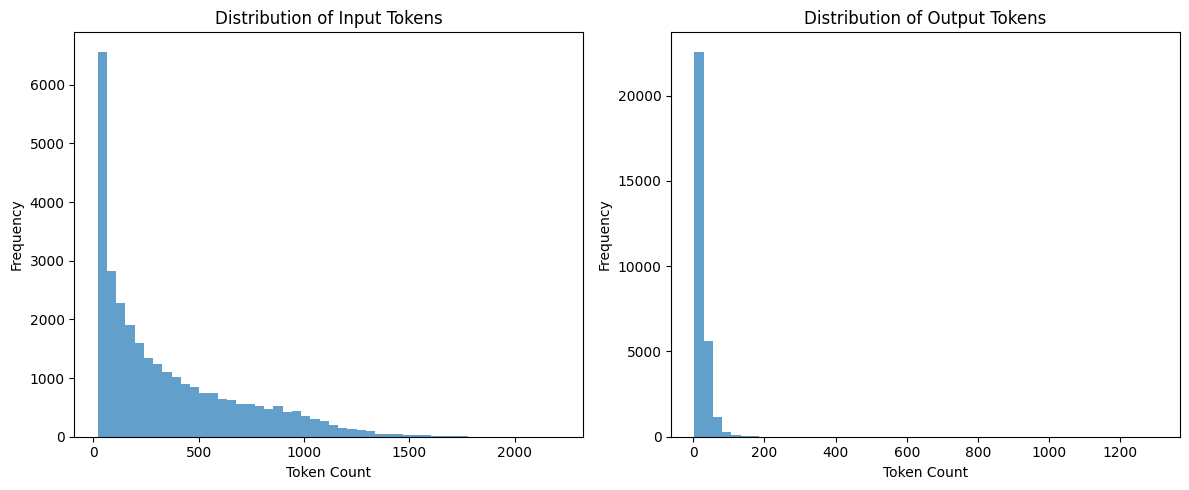

In [10]:
import tiktoken
import json
import matplotlib.pyplot as plt
import numpy as np

def analyze_token_distribution(dataset_path, encoding_name="cl100k_base"):
    # Initialize tokenizer
    encoding = tiktoken.get_encoding(encoding_name)
    
    # Load the dataset
    with open(dataset_path, 'r', encoding='utf-8') as f:
        dataset = json.load(f)
    
    # Lists to store token counts
    input_tokens = []
    output_tokens = []
    
    for example in dataset:
        input_len = len(encoding.encode(example['input']))
        output_len = len(encoding.encode(example['output']))
        
        input_tokens.append(input_len)
        output_tokens.append(output_len)
    
    # Calculate statistics
    print(f"Token Length Statistics:")
    print(f"\nInput Tokens:")
    print(f"Mean: {np.mean(input_tokens):.1f}")
    print(f"Median: {np.median(input_tokens):.1f}")
    print(f"Max: {max(input_tokens)}")
    print(f"Min: {min(input_tokens)}")
    print(f"95th percentile: {np.percentile(input_tokens, 95):.1f}")
    
    print(f"\nOutput Tokens:")
    print(f"Mean: {np.mean(output_tokens):.1f}")
    print(f"Median: {np.median(output_tokens):.1f}")
    print(f"Max: {max(output_tokens)}")
    print(f"Min: {min(output_tokens)}")
    print(f"95th percentile: {np.percentile(output_tokens, 95):.1f}")
    
    # Create histogram
    plt.figure(figsize=(12, 5))
    
    # Plot histograms
    plt.subplot(1, 2, 1)
    plt.hist(input_tokens, bins=50, alpha=0.7)
    plt.title('Distribution of Input Tokens')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(output_tokens, bins=50, alpha=0.7)
    plt.title('Distribution of Output Tokens')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Analyze the dataset
analyze_token_distribution('LLaMA-Factory/data/impersona_imessage_0buffer_B29k.json')

Random check script if useful

In [ ]:
import json
def search_phrases_in_dataset(dataset_path, phrases):
    """
    Search for specific phrases in the dataset and show their context.
    
    Args:
        dataset_path (str): Path to the JSON dataset
        phrases (list): List of phrases to search for
    """
    # Load the dataset
    with open(dataset_path, 'r', encoding='utf-8') as f:
        dataset = json.load(f)
    
    for phrase in phrases:
        print(f"\nSearching for phrase: '{phrase}'")
        print("-" * 50)
        
        count = 0
        for idx, example in enumerate(dataset):
            # Search in both input and output
            if phrase.lower() in example['input'].lower():
                count += 1
                print(f"Found in input (example {idx}):")
                print(f"Context: ...{example['input'][-100:]}") # Show last 100 chars for context
                
            if phrase.lower() in example['output'].lower():
                count += 1
                print(f"Found in output (example {idx}):")
                print(f"Full output: {example['output']}")
        
        print(f"\nTotal occurrences of '{phrase}': {count}")

phrases_to_search = [
    "I've been wanting to go to nyc"
]

search_phrases_in_dataset('LLaMA-Factory/data/impersona_imessage_0buffer_8192.json', phrases_to_search)